parsing equations from strings sandbox

In [1]:
from clspde.solution import lp as l
from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

def dir(point: np.array) -> np.array:
            direction = (np.abs(point) == 1) * (np.sign(point)) 
            return np.array(direction, dtype=int)

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

def Bx(x):
    #border condition for x
    return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])

function_list = ['m', 'v']
variable_list = ['t','x']

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)

In [2]:
power = 5

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,0.1], [0.2*np.pi,0.8*np.pi]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)


c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.5

colloc_left_operators = [
    #KFP
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),
    #HJB
    lp('- (d/dt) v - eps * (d/dx)^2 v + (d/dx) v * (d/dx) &v')
]

colloc_right_operators = [
    #KFP
    lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),
    #HJB
    lp('f(x) + ( (d/dx) &v )**2 /2'),
]

def initial_state(x):
    t, x = x
    return np.sin(x)

def terminal_state(x):
    t, x = x
    return -eps*np.log(np.sin(x)) - (-eps*np.log(np.sin(sol.area_lims[1,0])))

def f(x):
    t, x = x
    return -eps**2 *(np.sin(x)**(-2) + np.tan(x)**(-2)/2)

border_left_operators = [
    lp('Bx(x) * v'),
    lp('BtT(x) * ( m - v )'),
    lp('Bx(x) * m'),
    lp('BtI(x) * m'),
]
border_right_operators = [
    lp('Bx(x)* terminal_state(x)'),
    lp('BtT(x) * (initial_state(x) - terminal_state(x))'),
    lp('Bx(x)*initial_state(x)'),
    lp('BtI(x)*initial_state(x)'),
]

connect_left_operators = []
connect_right_operators = []

#TODO fix for lp to use func_num!
for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

In [4]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs, func_num=0, derivatives = [0,0]):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), derivatives, func_num)
    return res_array

exact_sol = np.zeros((len(ts), len(xs)))
for i in range(len(ts)):
    t = ts[i]
    for j in range(len(xs)):
        x = xs[j]
        exact_sol[i,j] = initial_state(np.array([t,x]))

new_eval=ev(sol)
division_counter = 0
print(' \t| ', 'Coefs change','\t\t| ', 'Solution change', '\t\t| ', 'Solution error')

for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    err = np.max(np.abs(new_eval - exact_sol))
    cost_func = np.sum((ev(sol,ts,xs,1, [0,1]))**2)

    print(j,'\t| ', np.max(np.abs(prev_coefs - sol.cells_coefs)),  '\t| ', change, '\t| ', err, '\t| ', cost_func)
    if change < 1e-9:
        division_counter +=1
        sol.cell_division(division_counter % 2)
        print('---cells dividied---')
    if err < 1e-8:
        break

 	|  Coefs change 		|  Solution change 		|  Solution error
0 	|  0.04108766804714023 	|  0.04925018076815657 	|  0.007699972574470637 	|  55.28236718205244
1 	|  0.0004071422952244483 	|  0.0005262100696723504 	|  0.007670081670773099 	|  55.55699762772778
2 	|  4.867801034053737e-06 	|  3.23382569766828e-06 	|  0.007670830052132427 	|  55.552733539731506
3 	|  9.793839185825992e-08 	|  6.822246390036923e-08 	|  0.007670805949219872 	|  55.552808058782915
4 	|  1.7355741704916383e-09 	|  1.2122169934514204e-09 	|  0.007670806351412596 	|  55.55280671634626
5 	|  3.2237733316176076e-11 	|  2.4101609596982598e-11 	|  0.007670806343149206 	|  55.55280674033585
---cells dividied---
6 	|  0.02280496031834159 	|  0.009229616936683449 	|  0.01007194961142932 	|  18.512997175117007
7 	|  0.00036903392361475884 	|  0.00018899202035227436 	|  0.01001277475446849 	|  18.431027692125795
8 	|  4.230098785806824e-06 	|  2.521009309086608e-06 	|  0.010013969130331812 	|  18.432603579199554
9 	|  1.13

KeyboardInterrupt: 

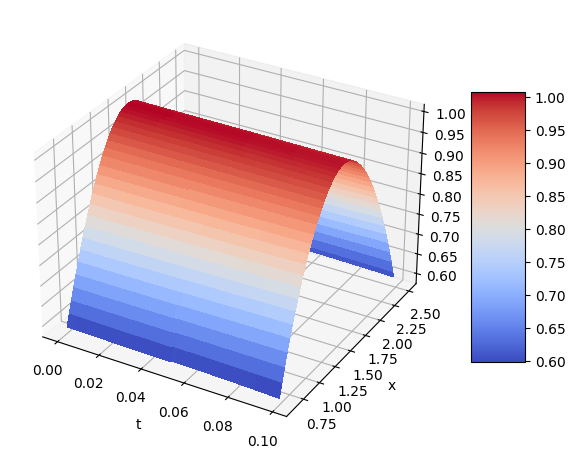

In [57]:
sol.plot2d(func_num=0)

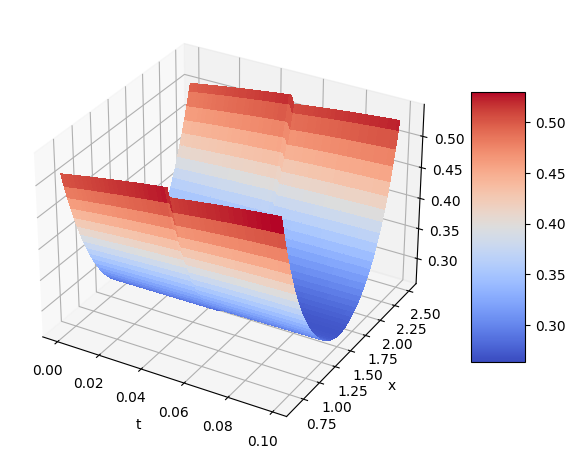

In [58]:
sol.plot2d(func_num=1)

In [35]:
sol.cell_division(1)

## Dynamical example

In [67]:
power = 5

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[1,1.1], [0.2*np.pi,0.8*np.pi]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.5
c = eps
colloc_left_operators = [
    #KFP
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),
    #HJB
    lp('- (d/dt) v - eps * (d/dx)^2 v + (d/dx) v * (d/dx) &v')
]

colloc_right_operators = [
    #KFP
    lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),
    #HJB
    lp('f(x) + ( (d/dx) &v )**2 /2'),
]

def initial_state(x):
    t, x = x
    return np.exp(-t*x) * t/(1-np.exp(-t))

def terminal_state(x):
    t, x = x
    return x**2 / 2/t + x*( (t+1)*(np.exp(t)-1)/(t**2) - eps*t)

def f(x):
    t, x = x
    return ( np.exp(-2*t)/(2*t**6) * (-2*np.exp(t)*((t-2)*(t+1)*(c*t**3+t+2)+
                                                  (t-2)*(t+1)*t**3*x*np.log(t) + 
                                                  (t**3-4*t-6)*t**2*x)-
                                    np.exp(2*t)*(t**3*np.log(t))*(2*c*t**3*(x+1)+t**3*x**2*np.log(t)+2*(t+2)*x)+
                                    (c*t**3+t+2)**2+t**5*(-x**2)+4*(t+3)*t**2*x-(t-2)**2*(t+1)**2) )
# scopes may be wrong!

border_left_operators = [
    lp('Bx(x) * v'),
    lp('BtT(x) * ( m - v )'),
    lp('Bx(x) * m'),
    lp('BtI(x) * m'),
]
border_right_operators = [
    lp('Bx(x)* terminal_state(x)'),
    lp('BtT(x) * (initial_state(x) - terminal_state(x))'),
    lp('Bx(x)*initial_state(x)'),
    lp('BtI(x)*initial_state(x)'),
]

connect_left_operators = []
connect_right_operators = []

for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

0  |  8.538003332849229  |  0.8457150135959012  |  0.06314014686038227
1  |  0.7858452360163408  |  0.08998942357647177  |  0.07579592370377619
2  |  0.14110061352516912  |  0.046323164571036246  |  0.08072898085280344
3  |  0.029714854514821518  |  0.00919122957458307  |  0.07377565741177286
4  |  0.010907634678955391  |  0.004423995336350212  |  0.07604537105565914
5  |  0.0036886405217594898  |  0.00111716281549612  |  0.07532535323019451
6  |  0.00122899164742582  |  0.00039842322468652824  |  0.07557587300636756
7  |  0.00042278608058499145  |  0.00013179755764400336  |  0.07549138234135169
8  |  0.00014344870042282132  |  4.568719493749929e-05  |  0.07552054315532361
9  |  4.9056158313215414e-05  |  1.544868400049637e-05  |  0.07551064495245205
10  |  1.670889433971756e-05  |  5.293577483272971e-06  |  0.07551403367058773
11  |  5.703013947921942e-06  |  1.8011389846805947e-06  |  0.07551287968632844
12  |  1.9443994304646495e-06  |  6.150950472016969e-07  |  0.07551327369146846


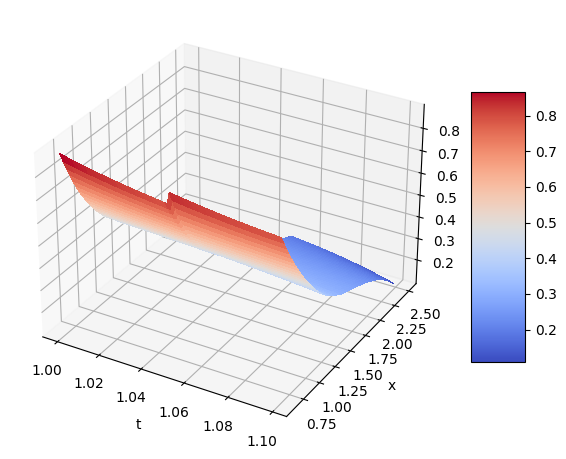

19  |  0.4430978455077508  |  0.09495986224890993  |  0.0656816941352576
20  |  0.02146768387040504  |  0.011929147947645241  |  0.06789280609648096
21  |  0.0022153259336108455  |  0.0005988543795707457  |  0.06830317347261494
22  |  0.00013851392263321272  |  5.247305414288195e-05  |  0.06827346044509641
23  |  1.1333089273257713e-05  |  2.2143289568621327e-06  |  0.06827567477405327
24  |  8.256307622023229e-07  |  2.7715571576658604e-07  |  0.06827550460861742
25  |  6.957394260709293e-08  |  1.2068483878913128e-08  |  0.0682755166771013
26  |  5.162909877398647e-09  |  1.520707060276294e-09  |  0.06827551572543122
27  |  4.339739678727028e-10  |  6.563793952807373e-11  |  0.06827551579106916


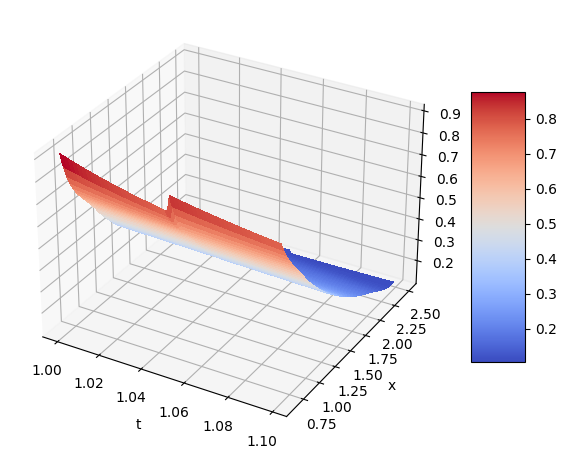

28  |  0.4409325069354928  |  0.0497789724991472  |  0.08483179923920103
29  |  0.041424020675652734  |  0.022093037945904698  |  0.08142033646126212
30  |  0.006354681738914181  |  0.0040061027613979006  |  0.0816742834544012
31  |  0.0016890852771371812  |  0.0007762445961109754  |  0.08165364237655315
32  |  0.00027458860935958285  |  0.00011919032916443695  |  0.0816535378423775
33  |  7.486232153386396e-05  |  3.4361524049925096e-05  |  0.08165343366878564
34  |  1.3717327726842088e-05  |  4.6367490527665645e-06  |  0.08165340673966681
35  |  3.7505957668493295e-06  |  1.6864130232829844e-06  |  0.08165340652676345
36  |  7.470830500899694e-07  |  1.8675119657640682e-07  |  0.08165340526053178
37  |  1.928706541143299e-07  |  8.488676173090681e-08  |  0.08165340531833876
38  |  4.209470416682848e-08  |  9.686686813781265e-09  |  0.0816534052575687
39  |  1.0242035886065537e-08  |  4.3718952347227e-09  |  0.08165340526259723
40  |  2.3685458039324203e-09  |  6.185961742843915e-10  

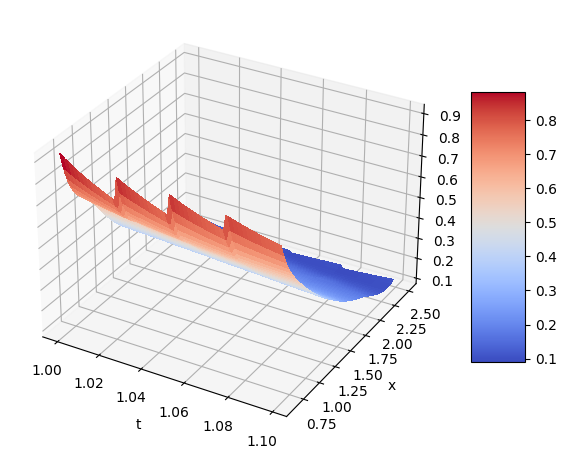

41  |  0.5316427628611677  |  0.053409993113782805  |  0.1071389653199537
42  |  0.20827930541003714  |  0.0345435509956548  |  0.10487620927798436
43  |  0.03820267769201726  |  0.010630977492186389  |  0.10733199159327234
44  |  0.004378758922456205  |  0.0010995300165229094  |  0.10694882599698319
45  |  0.00149803527563655  |  0.0004457587695826659  |  0.10700752944051406
46  |  0.000649568915648685  |  0.00019287038575810378  |  0.10699850834879399
47  |  0.00027340513095433505  |  8.349718749406376e-05  |  0.10699986573776987
48  |  0.00011728998114318712  |  3.564034106823266e-05  |  0.10699965996754635
49  |  5.0044097644419416e-05  |  1.524335937341803e-05  |  0.10699969044266955
50  |  2.1396447032168142e-05  |  6.512476536962852e-06  |  0.10699968598802245
51  |  9.141680400948093e-06  |  2.7832588134490965e-06  |  0.10699968657684522
52  |  3.906795490699055e-06  |  1.1893348172697937e-06  |  0.10699968652213376
53  |  1.6694577056608484e-06  |  5.082471628559126e-07  |  0.

KeyboardInterrupt: 

In [68]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
    return res_array

exact_sol = np.zeros((len(ts), len(xs)))
for i in range(len(ts)):
    t = ts[i]
    for j in range(len(xs)):
        x = xs[j]
        exact_sol[i,j] = initial_state(np.array([t,x]))

new_eval=ev(sol)
division_counter = 0
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    err = np.max(np.abs(new_eval - exact_sol))
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', change, ' | ', err)
    if change < 1e-9:
        sol.plot2d()
        division_counter +=1
        sol.cell_division(division_counter % 2)
    if err < 1e-8:
        break

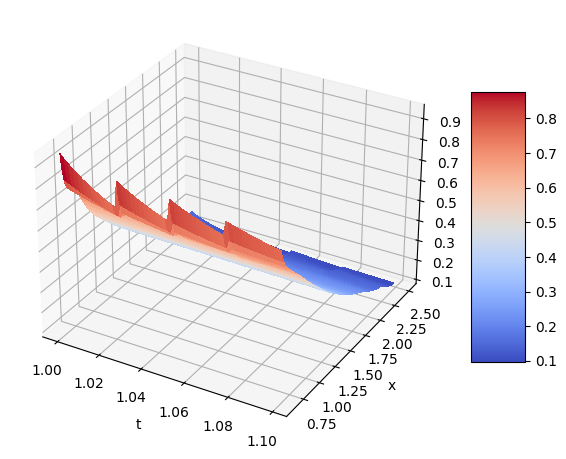

In [69]:
sol.plot2d(func_num=0)

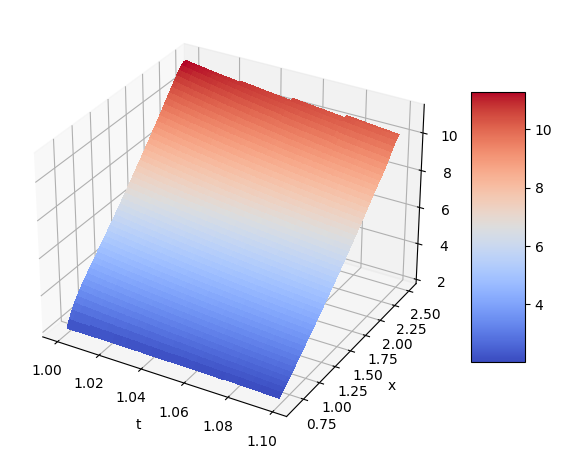

In [70]:
sol.plot2d(func_num=1)

In [132]:
power = 3

c_p_1d = f_collocation_points(power).reshape(power+1)
colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))

params = {
        'n_dims': 2,
        'dim_sizes': np.array([2, 2]),
        'area_lims': np.array([[0,1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }

sol = Solution(**params)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
eps = 0.14

c0=1
c1=0.1
c2=1
c3=0.8

colloc_left_operators = [
    #KFP
    lp('(d/dt) m - eps * (d/dx)^2 m - ( (d/dx) m * (d/dx) &v + (d/dx) &m * (d/dx) v +' +
                                        ' m * (d/dx)^2 &v + &m * (d/dx)^2 v )'),
    #HJB
    lp('(d/dt) v + eps * (d/dx)^2 v - (d/dx) v * (d/dx) &v /2 + m * c0*x[1]/(c1+c2* &m )**2')
]

colloc_right_operators = [
    #KFP
    lp('(- (d/dx) &m * (d/dx) &v - &m * (d/dx)^2 &v )'),
    #HJB
    lp('(- (d/dx) &v )**2 /4 - p(x[1])*(1-c3*x[0]) - c0*x[1]/(c1+c2* &m )'),
]

xc = (sol.area_lims[1,0]+sol.area_lims[1,1])/2
epsC = 0.01
a=1/np.sqrt(epsC**(1.5)*np.pi) * np.exp(-(xc)**2/epsC)

def initial_state(x):
    t, x = x
    return 1/np.sqrt(epsC*np.pi) * np.exp(-(x-xc)**2/epsC) + a*(x-xc)**2

def p(t):
    return 1

b_w = 10

border_left_operators = [
    lp('Bx(x) * (d/dx) v *b_w'),
    lp('BtT(x) * v *b_w'),
    lp('Bx(x) * (d/dx) m *b_w'),
    lp('BtI(x) * m * b_w'),
]
border_right_operators = [
    lp('Bx(x)* 0'),
    lp('BtT(x)* 0'),
    lp('Bx(x)* 0'),
    lp('BtI(x)*initial_state(x) * b_w'),
]

connect_left_operators = []
connect_right_operators = []

for func_num in range(sol.n_funcs):
    connect_left_operators += [
        lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc), func_num) + 
        np.sum(dir(x_loc))*u_bas(dir(x_loc),func_num)* np.all(np.array([0,1])==[0,1]),
        ]
    connect_right_operators += [
        lambda _, u_nei, x, x_loc, func_num=func_num: u_nei(0*dir(x_loc), func_num) - 
        np.sum(dir(x_loc))*u_nei(dir(x_loc),func_num)* np.all(np.array([0,-1])==[0,-1]),
        ]

border_ops = [border_left_operators, border_right_operators]
colloc_ops = [colloc_left_operators, colloc_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

points = (colloc_points, connect_points, border_points)

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
        'connect_ops':connect_ops,
        'function_list': ['m', 'v'],
        'variable_list': ['x', 'y']}

In [133]:
import copy
k=200
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
    return res_array

new_eval=ev(sol)
division_counter = 0
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', alpha = 0., svd_threshold=1e-8, return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    # err = np.max(np.abs(new_eval - exact_sol))
    print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', change)
    if change < 1e-9:
        sol.plot2d()
        division_counter +=1
        sol.cell_division(division_counter % 2)
    if err < 1e-8:
        break

0  |  5.572319704134625  |  0.946601150607311
1  |  4.379173116318617  |  0.46334980476479426
2  |  0.8025860454148158  |  0.5289810412231098
3  |  1.0066675518461599  |  1.0904860308114186
4  |  7.188565383303473  |  5.998780440683908
5  |  6.388578795916042  |  2.9306698662471202
6  |  5.639447692005918  |  7.168848036816069
7  |  1232.8553477372698  |  383.7891659085819
8  |  1210.6363142115658  |  185.98556794011932
9  |  359.06160515741556  |  407.4474260842223
10  |  429.0148018092448  |  388.05206716710006
11  |  509.886490280087  |  969.830023999589
12  |  733.0597509067077  |  1591.4356428048868
13  |  434.055676630985  |  555.9792301696962
14  |  121.07903125276441  |  108.31838081589629
15  |  55.3791381492091  |  78.19378006860455
16  |  13.652053803851022  |  10.75670437740064
17  |  12.82261581674696  |  16.945496883172627
18  |  3.6857319398718125  |  3.384516239283178
19  |  272.06955475696316  |  101.37064188903251
20  |  289.0238261698685  |  50.84556991193372
21  |  

KeyboardInterrupt: 

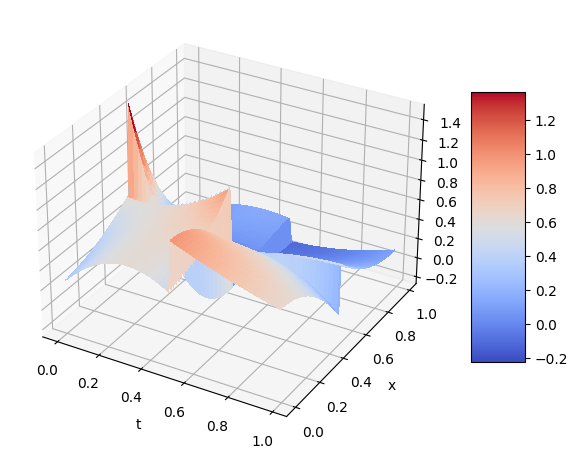

In [134]:
sol.plot2d()

In [128]:
sol.cell_division(0)

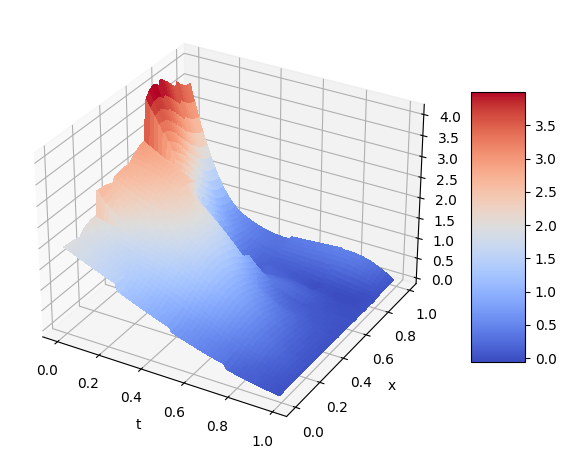

In [131]:
sol.plot2d(func_num=1)